In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## load Washington DC data

In [2]:
train = pd.read_csv('DC.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear
print(train.shape)
train.head()

(31208, 16)


,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
0,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-01,-0.261498,NaN,24.5,30.491773,19.317666,1.0,24.5,245
1,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-02,-1.162228,NaN,22.4,27.697930,17.862821,1.0,46.9,246
2,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-03,4.665462,NaN,23.3,28.614220,18.088451,1.0,70.2,247
3,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-04,7.307400,NaN,23.9,29.356041,18.830908,1.0,94.1,248
4,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-05,-1.383251,NaN,23.3,28.789929,17.415694,1.0,117.4,249


In [3]:
train.describe()

,lat,long,alt,year,bloom_doy,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
count,3.116800e+04,3.116800e+04,31168.0,31208.000000,31168.000000,31208.000000,0.0,31208.000000,31208.000000,31208.000000,31168.000000,31208.000000,31208.000000
mean,3.888535e+01,-7.703863e+01,0.0,1978.887689,93.347215,2.814608,NaN,14.424693,19.345355,9.665757,0.748203,2407.666633,183.393745
std,1.179592e-07,6.487758e-07,0.0,24.667193,7.003289,7.640025,NaN,9.438783,10.047955,9.252062,0.434052,1927.165818,105.627480
min,3.888535e+01,-7.703863e+01,0.0,1936.000000,74.000000,-5.282122,NaN,-17.800000,-13.300000,-20.600000,0.000000,-145.600000,1.000000
25%,3.888535e+01,-7.703863e+01,0.0,1958.000000,88.000000,0.000000,NaN,6.599183,11.100000,2.200000,0.000000,442.010775,92.000000
50%,3.888535e+01,-7.703863e+01,0.0,1979.000000,94.000000,0.000000,NaN,14.882100,20.150864,9.400000,1.000000,2154.083500,184.000000
75%,3.888535e+01,-7.703863e+01,0.0,2000.000000,98.000000,2.000000,NaN,22.859640,28.300000,18.300000,1.000000,4371.037750,275.000000
max,3.888535e+01,-7.703863e+01,0.0,2022.000000,108.000000,155.200000,NaN,34.049470,40.600000,28.900000,1.000000,5971.624000,366.000000


## $\log{\frac{P_t}{1-P_t}} = \beta_0 + \beta_1 t + \beta_2 \text{CDD}_t$

## $\text{CDD}_t = \sum_{i=1}^{t}T $

## plot lower and upper bound

In [4]:
# return the upper and lower bound near p_doy, from year start to year end
def p_doy_bound(start, end):
    
    # return upper, lower, beta0, beta1, beta2
    upper = np.zeros(end - start + 1)
    lower = np.zeros(end - start + 1)
    beta0 = np.zeros(end - start + 1)
    beta1 = np.zeros(end - start + 1)
    beta2 = np.zeros(end - start + 1)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # create data column
        train_year = train[train['year'] == year][:180]
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # fitting
        pred_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
        pred_model.fit(X, y)
        beta = pred_model.coef_
        
        # get probability vs. doy function
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, beta.T) - pred_model.intercept_)))
        
        # get upper and lower bound
        day_bloom = int(np.array(train_year['bloom_doy'])[0])
        for i in range(0, 180):
            if p_days[i + 1, 0] > 0.5:
                lower[year - start] = p_days[i, 0]
                upper[year - start] = p_days[i + 1, 0]
                break
                
        beta0[year - start] = pred_model.intercept_[0]
        beta1[year - start] = beta[0, 0]
        beta2[year - start] = beta[0, 1]
        
    return upper, lower, beta0, beta1, beta2

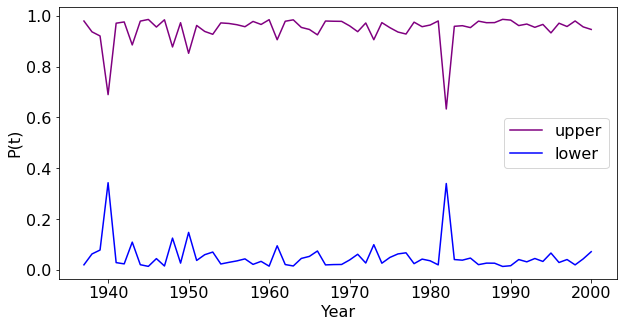

In [5]:
# plot the upper, lower bound vs. year
start = 1937
end = 2000
result = p_doy_bound(start, end)
# result[0]: upper
# result[1]: lower
# result[2]: beta0
# result[3]: beta1
# result[4]: beta2
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[0], color = 'purple', label = 'upper')
plt.plot(x, result[1], color = 'blue', label = 'lower')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("P(t)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

avg =  -228.07124950422485
std =  69.32775311207473


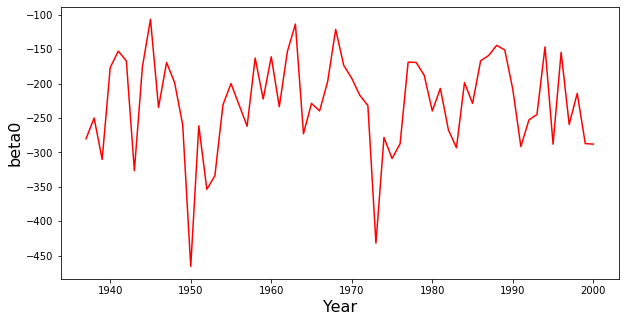

avg =  0.05725962275663471
std =  0.07118649622724477


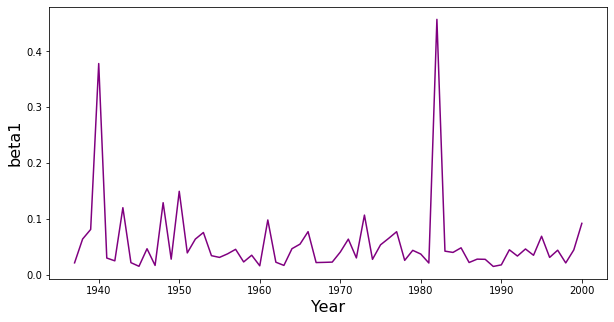

avg =  0.5046112587189027
std =  0.09534264227827934


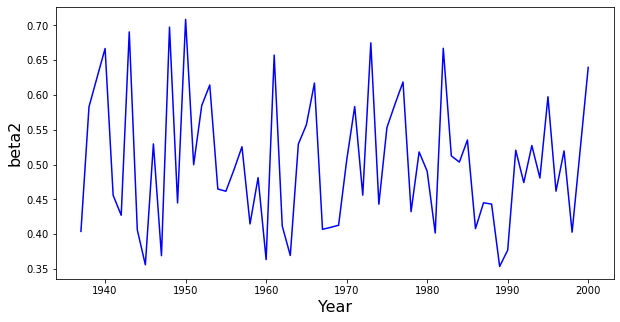

In [6]:
start = 1937
end = 2000
result = p_doy_bound(start, end)
# print("beta_0: ", result[2])
# print("beta_1: ", result[3])
# print("beta_2: ", result[4])
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[2], color = 'red')
print("avg = ", np.average(result[2]))
print("std = ", np.std(result[2]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta0", fontsize = 16)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[3], color = 'purple')
print("avg = ", np.average(result[3]))
print("std = ", np.std(result[3]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta1", fontsize = 16)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[4], color = 'blue')
print("avg = ", np.average(result[4]))
print("std = ", np.std(result[4]))
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta2", fontsize = 16)
plt.show()

## $\beta_i$ time series

### $\beta_0, \beta_1, \beta_2$ lag plot

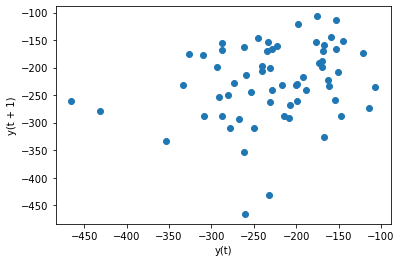

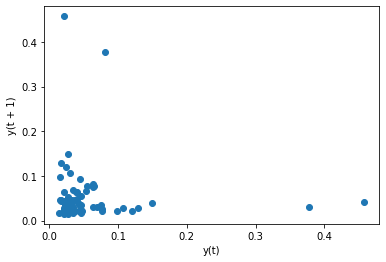

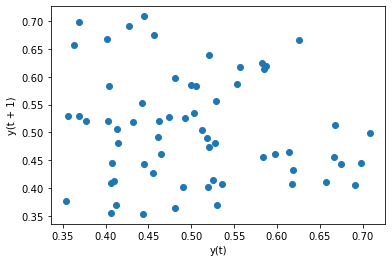

In [7]:
lag_plot(pd.Series(result[2]), lag=1)
plt.show()
lag_plot(pd.Series(result[3]), lag=1)
plt.show()
lag_plot(pd.Series(result[4]), lag=1)
plt.show()

### $\beta_0, \beta_1, \beta_2$ Autocorrection plot

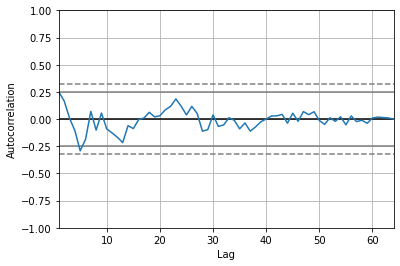

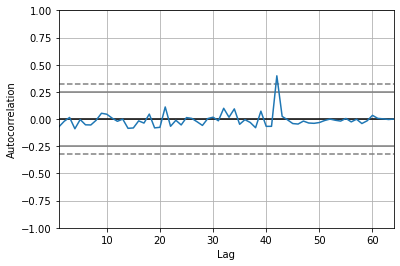

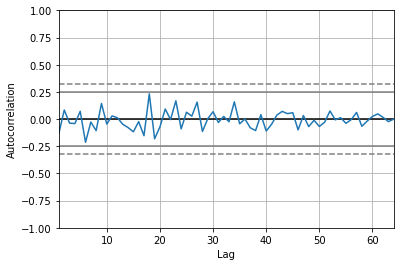

In [8]:
autocorrelation_plot(result[2])
plt.show()
autocorrelation_plot(result[3])
plt.show()
autocorrelation_plot(result[4])
plt.show()

## time series prediction - AutoReg

In [9]:
beta0_model = AutoReg(result[2], lags = 5).fit()
beta0_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:                     AutoReg(5)   Log Likelihood                -329.025
Method:               Conditional MLE   S.D. of innovations             63.928
Date:                Sun, 27 Feb 2022   AIC                              8.553
Time:                        22:13:20   BIC                              8.799
Sample:                             5   HQIC                             8.649
                                   64                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -224.2902     49.097     -4.568      0.000    -320.519    -128.062
y.L1           0.1873      0.124      1.507      0.132      -0.056       0.431
y.L2           0.1463      0.126      1.158      0.247      -0.101       0.394
y.L3           0.0162      0.126      0.129      0.898      -0.230       0.263
y.L4          -0.0539      0.125     -0.431      0.667      -0.299       0.192
y.L5          -0.2780      0.124     -2.246      0.025      -0.521      -0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0204           -0.6338j            1.2012           -0.0885
AR.2            1.0204           +0.6338j            1.2012            0.0885
AR.3           -1.3400           -0.0000j            1.3400           -0.5000
AR.4           -0.4474           -1.2886j            1.3640           -0.3032
AR.5           -0.4474           +1.2886j            1.3640            0.3032
-----------------------------------------------------------------------------
"""

## Compare the $\beta_i$

In [10]:
start = 1937
end = 2000
result_val = p_doy_bound(2001, 2021)

## $p$ value:
$\beta_0$: 9

$\beta_1$: 2

$\beta_2$: 13

In [11]:
result[2]

array([-280.08748249, -250.17648572, -310.13513578, -176.82744787,
       -152.95793016, -167.04313605, -326.51569084, -175.52126718,
       -106.76351411, -234.71521583, -169.4254379 , -198.79201096,
       -259.92757024, -465.71192393, -261.31640609, -353.64453504,
       -333.92239345, -231.05418157, -199.98655687, -230.93356069,
       -262.02752348, -163.02338885, -222.47279548, -161.09562497,
       -233.60293469, -153.58760558, -113.63787838, -272.85464508,
       -228.77625924, -239.83357604, -197.43552975, -121.38247144,
       -173.53608265, -192.47507819, -217.16998023, -231.93332415,
       -431.75072467, -278.25212287, -308.91322631, -287.4463173 ,
       -168.92908464, -169.39543163, -188.19669916, -239.89359091,
       -207.06346815, -267.23371307, -293.30355958, -198.60158523,
       -228.91742371, -167.07238986, -159.21349872, -144.49851427,
       -151.1508533 , -208.6450107 , -291.56565046, -252.91688135,
       -244.94548695, -146.73587405, -288.09404693, -154.60313

In [12]:
result_val[2]

array([-213.35624504, -305.8333546 , -121.85833012, -221.34027378,
       -253.1834163 , -276.76911814, -207.27659952, -241.09567642,
       -185.37155536, -190.23513033, -286.5742323 , -244.78130958,
       -200.67928357, -178.37837756, -214.21793183, -182.34473253,
       -247.76783744, -320.22237049, -353.92454901, -232.49670802,
       -207.75167897])

In [13]:
result[3]

array([0.02139364, 0.06404033, 0.08119051, 0.37827502, 0.03000518,
       0.02498499, 0.12014821, 0.0217338 , 0.01521451, 0.04663866,
       0.01677527, 0.12910024, 0.02800224, 0.14951081, 0.03917352,
       0.06390864, 0.07572465, 0.03422127, 0.03114359, 0.03749153,
       0.04559813, 0.02300848, 0.0350506 , 0.0160891 , 0.09816575,
       0.02252608, 0.0167999 , 0.04672933, 0.05489754, 0.0772518 ,
       0.02189389, 0.02225172, 0.02270278, 0.04065857, 0.06383378,
       0.03018785, 0.10687923, 0.02766626, 0.05366038, 0.06512762,
       0.07715743, 0.02583628, 0.04379344, 0.03711989, 0.02107793,
       0.45741101, 0.04232079, 0.04006166, 0.04830874, 0.02198095,
       0.02801757, 0.02768643, 0.01493843, 0.01774814, 0.04473892,
       0.03355311, 0.04623558, 0.03495746, 0.06901879, 0.03111685,
       0.04402535, 0.02123088, 0.0445145 , 0.09211035])

In [14]:
result_val[3]

array([0.02892892, 0.03440595, 0.02533586, 0.06247137, 0.03674754,
       0.0403509 , 0.03818941, 0.03159893, 0.04481176, 0.0291885 ,
       0.11194446, 0.02120933, 0.01643575, 0.03029822, 0.05392492,
       0.02122211, 0.02636273, 0.09000502, 0.13384378, 0.01992305,
       0.02702555])

In [15]:
result[4]

array([0.40403062, 0.58299776, 0.62507945, 0.66675549, 0.45593778,
       0.42724534, 0.69059681, 0.40622953, 0.35604983, 0.5297237 ,
       0.36918734, 0.69747772, 0.44493766, 0.70862941, 0.49979502,
       0.58474438, 0.61432102, 0.46489963, 0.46169742, 0.49235115,
       0.52566724, 0.41478735, 0.48121849, 0.36351011, 0.65728334,
       0.41175417, 0.3694621 , 0.52940515, 0.55722742, 0.61711219,
       0.40696778, 0.4098017 , 0.41283785, 0.50582225, 0.58341285,
       0.45608665, 0.67487418, 0.44308824, 0.55309286, 0.58677053,
       0.61865413, 0.43236362, 0.51816354, 0.49045876, 0.40176665,
       0.66705319, 0.51256616, 0.50356059, 0.53531913, 0.40803495,
       0.44511575, 0.44322749, 0.35368665, 0.37707167, 0.52065426,
       0.47414489, 0.52739045, 0.48077085, 0.59743901, 0.46182252,
       0.51966695, 0.40291494, 0.52085465, 0.63955025])

In [16]:
result_val[4]

array([0.45031984, 0.47813618, 0.42840965, 0.58164993, 0.4888136 ,
       0.50433418, 0.49526665, 0.46315668, 0.52252173, 0.45166726,
       0.68560208, 0.40270005, 0.36643023, 0.45744836, 0.55419171,
       0.4026282 , 0.43270794, 0.63935411, 0.69786924, 0.39364451,
       0.43953647])

## Validation 2001 - 2000

In [17]:
beta0_model = AutoReg(result[2], lags = 9, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 3, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 13, trend='c').fit()
# validate the blooming doy
# return the predicted doy and the real doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1937
    
    predict = np.zeros(end - start + 1)
    real = np.zeros(end - start + 1)
    
    L_train = len(result[2])
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
#     beta0_pre = np.array([np.median(result[2])] * (end - start + 1))
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the real doy array
        CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        train_year = train[train['year'] == year][:180]
        real[year - start] = int(np.array(train_year['bloom_doy'])[0])
        
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
#         b0 = np.array([beta0_pre[year - start]])
        if CU < 6.5:
            b0 = np.array([beta0_pre[year - start] + 50])
        elif CU > 8:
            b0 = np.array([beta0_pre[year - start] - 40])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict, real


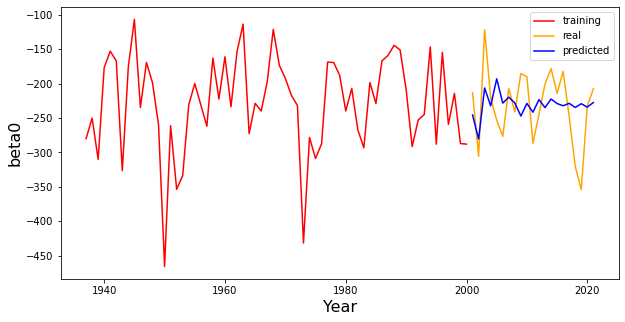

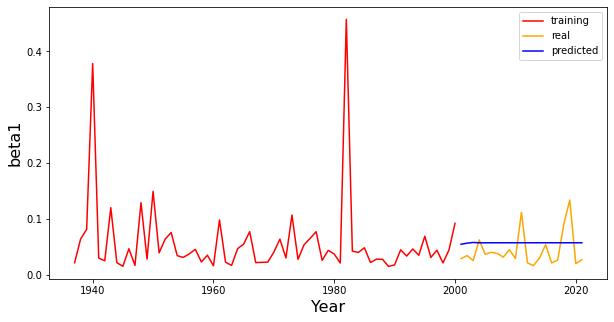

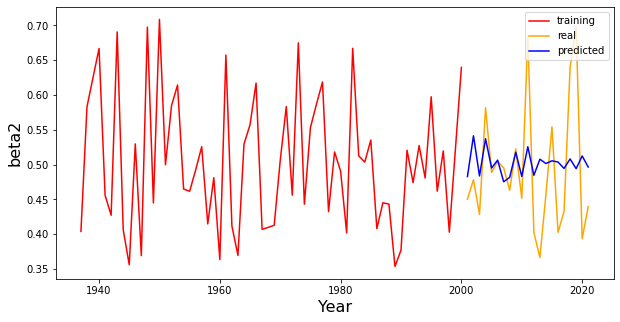

In [18]:
start = 1937
end = 2000
result_val = p_doy_bound(2001, 2021)
x = np.arange(start, end + 1)
x_v = np.arange(2001, 2021 + 1)
plt.figure(figsize=(10, 5))
plt.plot(x, result[2], color = 'red', label = 'training')
plt.plot(x_v, result_val[2], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta0_model.predict(2001-1937, 2021-1937, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta0", fontsize = 16)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[3], color = 'red', label = 'training')
plt.plot(x_v, result_val[3], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta1_model.predict(2001-1937, 2021-1937, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta1", fontsize = 16)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x, result[4], color = 'red', label = 'training')
plt.plot(x_v, result_val[4], color = 'orange', label = 'real')
plt.plot(np.arange(2001, 2021 + 1), beta2_model.predict(2001-1937, 2021-1937, dynamic=False), 
         color = 'blue', label = 'predicted')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("beta2", fontsize = 16)
plt.legend(loc='upper right')
plt.show()

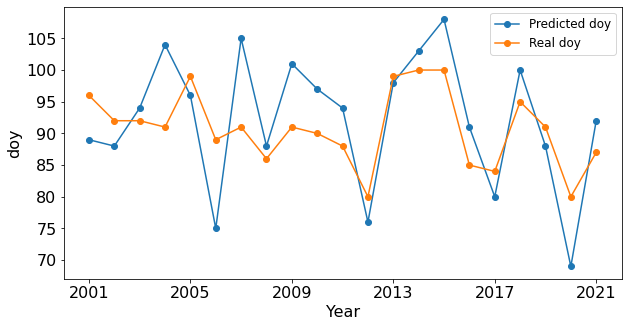

In [19]:
# plot the predict, real doy vs. year
start = 2001
end = 2021
result_pred_ts = predict_blooming_beta_ts(start, end)
x = np.arange(start, end + 1)

f = plt.figure(figsize=(10, 5))
plt.plot(x, result_pred_ts[0], 'o-', label = 'Predicted doy')
plt.plot(x, result_pred_ts[1], 'o-', label = 'Real doy')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
# plt.ylim([67, 115])
plt.xticks(np.arange(2001, 2022, 4), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title("th = 0.5")
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()
# f.savefig("../result_figures/washington_beta.png", bbox_inches='tight', dpi=1200)
# f.savefig("../result_figures/washington_beta_modified.png", bbox_inches='tight', dpi=1200)

In [20]:
np.array([np.average(train[train['year'] == y-1][-71:]['TAVG']) for y in range(2001, 2022)])

array([ 5.45915493, 10.6971831 ,  6.28450704,  8.52394366,  8.46619718,
        6.86898773,  8.80974665,  8.83123548,  6.83080923,  8.3813496 ,
        7.21335752,  9.44534086,  8.75811489,  7.6028169 ,  8.71690141,
       11.66478873,  8.8915493 ,  8.04538364,  7.72816901,  7.96478873,
        9.47887324])

## Test projected temperature 2001 - 2010

In [21]:
projection_start = 2000
projection_end = 2021
day_bloom_array = np.zeros(projection_end - projection_start + 1)
for y in range(projection_start, projection_end + 1):
    train_y = train[train['year'] == y]
    day_bloom_array[y - projection_start] = int(np.array(train_y['bloom_doy'])[0])
print(day_bloom_array)

[ 77.  96.  92.  92.  91.  99.  89.  91.  86.  91.  90.  88.  80.  99.
 100. 100.  85.  84.  95.  91.  80.  87.]


In [22]:
test = pd.read_csv('DC_temp_forecast_2000_2021.csv')
test['doy'] = pd.to_datetime(test['date']).dt.dayofyear
test['year'] = pd.to_datetime(test['date']).dt.year
test['Status'] = (test['doy'] >= day_bloom_array[test['year'] - projection_start]).astype(int)
print(train.shape)
test.head()

(31208, 16)


,Unnamed: 0,temp,date,CDD,doy,year,Status
0,1,-3.3,2000-01-01,-3.3,1,2000,0
1,2,-5.0,2000-01-02,-8.3,2,2000,0
2,3,4.4,2000-01-03,-3.9,3,2000,0
3,4,-2.8,2000-01-04,-6.7,4,2000,0
4,5,-5.6,2000-01-05,-12.3,5,2000,0


In [23]:
beta0_model = AutoReg(result[2], lags = 9, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 3, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 13, trend='c').fit()
# validate the blooming doy
# return the predicted doy and the real doy
def test_blooming_beta_ts(start, end):
    
    training_start = 1937
    
    predict = np.zeros(end - start + 1)
    real = day_bloom_array[1:11]
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the real doy array
        CU = np.average(test[test['year'] == year - 1][-71:]['temp'])
        test_year = test[test['year'] == year][:180]
        
        features = ['doy', 'CDD']
        X = test_year[features]
        y = test_year.Status
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
#         b0 = np.array([beta0_pre[year - start]])
        if CU < 6.5:
            b0 = np.array([beta0_pre[year - start] + 50])
        elif CU > 8:
            b0 = np.array([beta0_pre[year - start] - 40])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict, real


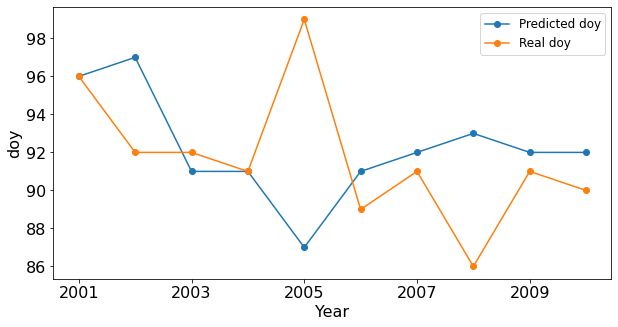

In [24]:
# plot the predict, real doy vs. year
start = 2001
end = 2010
result_test = test_blooming_beta_ts(start, end)
x = np.arange(start, end + 1)

f = plt.figure(figsize=(10, 5))
plt.plot(x, result_test[0], 'o-', label = 'Predicted doy')
plt.plot(x, result_test[1], 'o-', label = 'Real doy')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
plt.xticks(np.arange(2001, 2011, 2), fontsize = 16)
plt.yticks(fontsize = 16)
# plt.title("th = 0.5")
plt.legend(fontsize = 12, loc = 'upper right')
plt.show()
# f.savefig("../result_figures/washington_test_T_pred.png", bbox_inches='tight', dpi=1200)

In [25]:
print([np.average(test[test['year'] == year - 1][-71:]['temp']) for year in range(2001, 2011)])

[9.008450704225353, 9.008450704225353, 9.008450704225353, 9.008450704225353, 8.812676056338029, 8.812676056338029, 8.812676056338029, 8.812676056338029, 8.749295774647887, 8.749295774647887]
